In [0]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
%sql
use lakehouse

In [0]:
df = spark.read.format("delta").table("gold_tableforml")

In [0]:
df = df.toPandas()
print(df)

            type          address     area_m2  floor  bedroom  toilet  \
0          House    Quận Bình Tân   68.000000      4        4       5   
1          House     Quận Tân Phú   80.000000      0        5       4   
2          House      Quận Gò Vấp   40.000000      2        2       2   
3      Apartment  Quận Bình Thạnh   67.000000      0        2       2   
4          House           Quận 7  141.000000      5       11       7   
...          ...              ...         ...    ...      ...     ...   
12513      House      Quận Gò Vấp   43.200001      0        3       3   
12514       Land          Quận 12  125.000000      0        0       0   
12515      House      Quận Gò Vấp   20.000000      1        2       2   
12516  Apartment    Quận Bình Tân   64.000000      0        2       2   
12517      House    Quận Bình Tân   23.000000      2        2       2   

       furnishing_status legal_status  land_frontage  spacious_backyard  \
0      Không có nội thất     Đã có sổ           

In [0]:
df = df.drop("price_vnd", axis=1)

In [0]:
df['price_per_square'] = df['price_per_square'] / 1000000

def round_to_two_decimals(number):
  return round(number, 0)

df['price_per_square'] = df['price_per_square'].apply(round_to_two_decimals)
print(df['price_per_square'])

0         90.0
1         94.0
2        112.0
3         54.0
4        206.0
         ...  
12513    122.0
12514     68.0
12515    140.0
12516     27.0
12517    102.0
Name: price_per_square, Length: 12518, dtype: float64


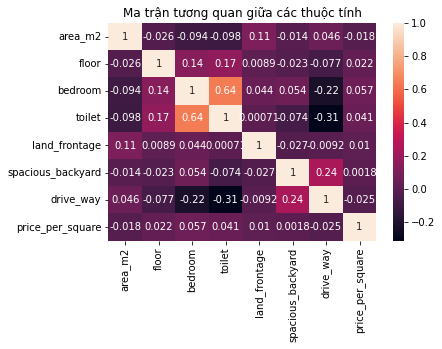

In [0]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)

plt.title("Ma trận tương quan giữa các thuộc tính")
plt.show()

In [0]:
def remove_outliers(data):
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    data_numeric = data[numeric_cols]

    Q1 = data_numeric.quantile(0.25)
    Q3 = data_numeric.quantile(0.75)
    IQR = Q3 - Q1
    return data[~((data_numeric < (Q1 - 1.5 * IQR)) | (data_numeric > (Q3 + 1.5 * IQR))).any(axis=1)]

df = remove_outliers(df)


In [0]:
label_encoder = LabelEncoder()
df['address'] = label_encoder.fit_transform(df['address'])
df['furnishing_status'] = label_encoder.fit_transform(df['furnishing_status'])
df['legal_status'] = label_encoder.fit_transform(df['legal_status'])
df['type'] = label_encoder.fit_transform(df['type'])
print(df)

       type  address     area_m2  floor  bedroom  toilet  furnishing_status  \
0         1       16   68.000000      4        4       5                  2   
1         1       20   80.000000      0        5       4                  2   
2         1       17   40.000000      2        2       2                  2   
3         0       15   67.000000      0        2       2                  2   
6         1       17   59.400002      4        3       4                  2   
...     ...      ...         ...    ...      ...     ...                ...   
12513     1       17   43.200001      0        3       3                  2   
12514     2        8  125.000000      0        0       0                  2   
12515     1       17   20.000000      1        2       2                  3   
12516     0       16   64.000000      0        2       2                  4   
12517     1       16   23.000000      2        2       2                  2   

       legal_status  land_frontage  spacious_backya

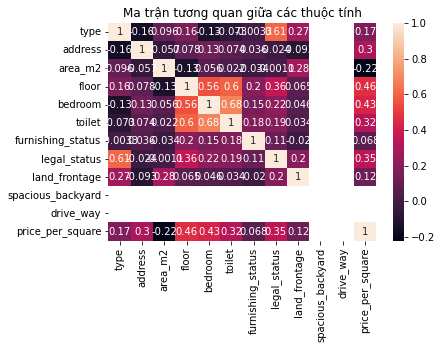

In [0]:

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)

plt.title("Ma trận tương quan giữa các thuộc tính")
plt.show()

In [0]:
def train_model(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=3)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{model_name} - MAE: {mae}')
    print(f'{model_name} - MSE: {mse}')
    print(f'{model_name} - R²: {r2}')
    return mae, mse, r2

In [0]:
features = ["type","address","area_m2","floor","furnishing_status","legal_status","bedroom","toilet","land_frontage","drive_way","spacious_backyard"]
X = df[features].values
y = df['price_per_square'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [0]:
# Linear Regression
lr = LinearRegression()
param_grid_lr = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1]
}
best_lr, best_params_lr = train_model(lr, param_grid_lr, X_train, y_train)
y_pred_lr = best_lr.predict(X_test)
mae_lr, mse_lr, r2_lr = evaluate_model(y_test, y_pred_lr, 'Linear Regression')

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Linear Regression - MAE: 27.103706895383
Linear Regression - MSE: 1235.8729249857918
Linear Regression - R²: 0.43409187551495365


In [0]:
# Random Forest
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
best_rf, best_params_rf = train_model(rf, param_grid_rf, X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
mae_rf, mse_rf, r2_rf = evaluate_model(y_test, y_pred_rf, 'Random Forest')

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [0]:
def plot_results(y_test, y_pred_lr, y_pred_rf):
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred_lr, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel('Actual Price per Square')
    plt.ylabel('Predicted Price per Square')
    plt.title('Linear Regression')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_rf, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
    plt.xlabel('Actual Price per Square')
    plt.ylabel('Predicted Price per Square')
    plt.title('Random Forest Regression')

    plt.tight_layout()
    plt.show()

In [0]:
if mae_lr < mae_rf:
    best_model = 'Linear Regression'
    best_mae = mae_lr
    best_mse = mse_lr
    best_r2 = r2_lr
else:
    best_model = 'Random Forest'
    best_mae = mae_rf
    best_mse = mse_rf
    best_r2 = r2_rf

print(f'Best Model: {best_model}')
print(f'Best Model - MAE: {best_mae}')
print(f'Best Model - MSE: {best_mse}')
print(f'Best Model - R²: {best_r2}')

plot_results(y_test, y_pred_lr, y_pred_rf)


In [0]:
def feature_importance(model_lr, model_rf, feature_names):
    # Linear Regression feature importance
    lr_importance = np.abs(model_lr.coef_)
    lr_importance = lr_importance / np.sum(lr_importance)  # Normalize to sum to 1
    lr_importance = lr_importance * 100  # Convert to percentage

    # Random Forest feature importance
    rf_importance = model_rf.feature_importances_ * 100  # Convert to percentage

    # Combine into a DataFrame for comparison
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Linear Regression Importance (%)': lr_importance,
        'Random Forest Importance (%)': rf_importance
    })
    importance_df = importance_df.sort_values(by='Random Forest Importance (%)', ascending=False)
    return importance_df

In [0]:
importance_df = feature_importance(best_lr, best_rf, features)
print("Feature Importance:\n", importance_df)